##### Copyright 2021 The Cirq Developers

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum circuits on Rigetti devices

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://quantumai.google/cirq/tutorials/rigetti/getting_started"><img src="https://quantumai.google/site-assets/images/buttons/quantumai_logo_1x.png" />View on QuantumAI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/quantumlib/Cirq/blob/master/docs/tutorials/rigetti/getting_started.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/quantumlib/Cirq/blob/master/docs/tutorials/rigetti/getting_started.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/github_logo_1x.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/Cirq/docs/tutorials/rigetti/getting_started.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/download_icon_1x.png" />Download notebook</a>
  </td>
</table>

In [1]:
try:
    import cirq
except ImportError:
    print("installing cirq...")
    !pip install --quiet cirq --pre
    print("installed cirq.")

In [2]:
import cirq

print(cirq.__version__)

0.12.0.dev


Note: this notebook relies on unreleased Cirq features. If you want to try these features, make sure you install cirq via `pip install cirq --pre`.

try:
    import pyquil
except ImportError:
    print("installing pyquil...")
    !pip install --quiet pyquil~=3.0.0
    print("installed pyquil.")

In [3]:
try:
    import pyquil
except ImportError:
    print("installing pyquil...")
    !pip install --quiet pyquil==3.0.0rc22
    print("installed pyquil.")

In [4]:
import pyquil
print(pyquil.__version__)

3.0.0rc22


# Running a Bell state circuit

To demonstrate the basic functionality of the Cirq Rigetti integration, we begin constructing a basic Bell state circuit.

In [5]:
bell_circuit = cirq.Circuit()
qubits = cirq.LineQubit.range(2)
bell_circuit.append(cirq.H(qubits[0]))
bell_circuit.append(cirq.CNOT(qubits[0], qubits[1]))
bell_circuit.append(cirq.measure(qubits[0], qubits[1], key='m'))
print(bell_circuit)

0: ───H───@───M('m')───
          │   │
1: ───────X───M────────


Next, we'll initialize a pyQuil quantum computer. Note, that this may be the pyQuil [Quantum Virtual Machine](https://pyquil-docs.rigetti.com/en/stable/migration.html) or a Rigetti hardware device. You may see a list of available Rigetti hardware devices by calling `RigettiQCSService.list_quantum_processors`. For now, we will just run our circuit against the pyQuil QVM.

In [7]:
from cirq_rigetti import RigettiQCSService
from pyquil import get_qc
import json

quantum_processors = RigettiQCSService.list_quantum_processors().quantum_processors
print(json.dumps([quantum_processor.id for quantum_processor in quantum_processors], sort_keys=True, indent=4))

# update this call with a hardware quantum processor id and set as_qvm and noisy to False,
# if you have Rigetti QCS access
qc = get_qc("9q-square", as_qvm=True, noisy=True)

[
    "Aspen-9"
]


Next, we'll instantiate the `RigettiQCSService` to run our circuit on the specified quantum computer.

In [8]:
from cirq_rigetti import circuit_transformers, circuit_sweep_executors, RigettiQCSService

service = RigettiQCSService(quantum_computer=qc)
result = service.run(bell_circuit, repetitions=1000)

print(result.histogram(key='m'))

Counter({0: 479, 3: 412, 2: 58, 1: 51})


We'll define a function to visually verify the results of our Bell state.

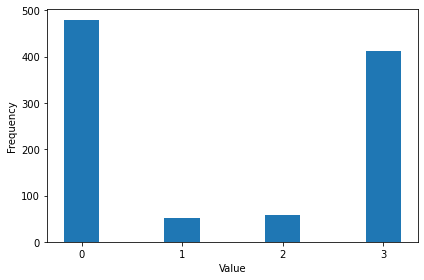

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bell_state(result):
    labels = list(result.keys())
    labels.sort()

    values = [result[label] for label in labels]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x, values, width, label='Bell state')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Frequency')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Value')

    fig.tight_layout()

    plt.show()
    
plot_bell_state(result.histogram(key='m'))

As expected, we see states 0 (ie '00') and 3 (ie '11') as the dominant results.

You may initialize both the `RigettiQCSService` and `RigettiQCSSampler` with execution functions from the `cirq_rigetti.circuit_sweep_executor` module and transformation functions from `cirq_rigetti.circuit_transformations`.

You may invoke these functions with arguments for controlling your circuit execution at a more fine grained level. For instance, you may want add [Pragma statements](https://pyquil-docs.rigetti.com/en/stable/compiler.html#region-specific-compiler-features-through-pragma) to set the [initial rewiring](https://pyquil-docs.rigetti.com/en/stable/compiler.html#initial-rewiring) strategy, invoke [active qubit reset](https://arxiv.org/abs/2001.04449) prior to execution, or explicitly address physical qubits on the quantum computer.

RESET
PRAGMA INITIAL_REWIRING "GREEDY"
DECLARE m0 BIT[2]
H 4
CNOT 4 5
MEASURE 4 m0[0]
MEASURE 5 m0[1]



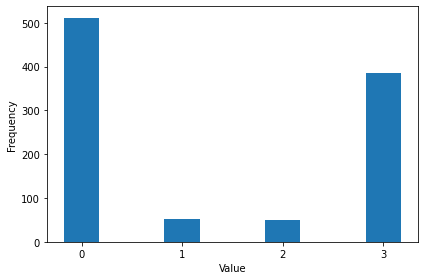

In [10]:
from pyquil.quilbase import Reset, Pragma

def hook(program, measurement_id_map):
    program._instructions.insert(0, Reset())
    program._instructions.insert(1, Pragma('INITIAL_REWIRING', freeform_string='GREEDY'))
    print(program)
    return program, measurement_id_map

# assign qubits explicitly to hardware or virtual machine qubits.
qubit_id_map = {
   qubits[0]: 4,
   qubits[1]: 5,
}
executor = executor = circuit_sweep_executors.with_quilc_compilation_and_cirq_parameter_resolution
transformer = circuit_transformers.build(qubit_id_map=qubit_id_map, qubits=qubits, post_transformation_hooks=[hook])
service = RigettiQCSService(quantum_computer=qc, executor=executor, transformer=transformer)
result = service.run(bell_circuit, repetitions=1000)

plot_bell_state(result.histogram(key='m'))

# Running a parameterized circuit

Of course, you may be running a parameterized circuit and would like to leverage the [Quil compilers](https://pyquil-docs.rigetti.com/en/stable/compiler.html)'s support for parametric compilation. This affords a speedup in execution times as the Cirq Rigetti integration will only compile the circuit once for a single parameter sweep.

We start by initializing the `RigettiQCSSampler` and specifying a circuit sweep executor that supports parametric compilation. Note, that this class accepts the same `executor` and `transformer` types as `RigettiQCSService`.

In [11]:
from cirq_rigetti import RigettiQCSSampler

executor = circuit_sweep_executors.with_quilc_parametric_compilation
sampler = RigettiQCSSampler(quantum_computer=qc, executor=executor)

Next, we will initialize a parameterized circuit in Cirq along with a set of parameter values.

In [12]:
import sympy

qubit = cirq.LineQubit.range(1)[0]

circuit = cirq.Circuit(
    cirq.H(qubit)**sympy.Symbol('t'),
    cirq.measure(qubit, key='m'))
params = cirq.Linspace('t', start=0, stop=4, length=5)

print(circuit)

0: ───H^t───M('m')───


In much the same way that we invoke, `RigettiQCSSerivce.run`, we invoke `RigettiQCSSampler.run_sweep` with our parameters here.

In [13]:
import pandas as pd

results = sampler.run_sweep(circuit, params, repetitions=10)
data = {f't={result.params["t"]}': [measurement[0] for measurement in result.measurements['m']] for result in results}

pd.DataFrame(data)

,t=0.0,t=1.0,t=2.0,t=3.0,t=4.0
0,0,0,0,0,0
1,0,1,0,1,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,1,0,1,0
5,0,1,0,0,0
6,0,1,0,1,0
7,0,0,0,1,0
8,0,0,0,0,0
9,0,0,0,0,0
